In [1]:
import torch, torchvision, os, PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

/home/joseph/miniconda3/envs/multimodal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/joseph/miniconda3/envs/multimodal/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def show(tensor, num=25, wandb=0, name=''):
    data = tensor.detach().cpu()
    grid = make_grid(data[:num], nrow=5).permute(1,2,0)
    
    ## optional
    if (wandb==1 and wandbact==1): # wandb : weights and biases (online tool)
        wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})
    
    plt.imshow(grid.clip(0,1)) # clip the values of the pixles to be inbetween 0~1
    plt.show()
    
### hyperparameters and general parameters
n_epochs = 10000
batch_size = 128
lr = 1e-4
z_dim = 200
device='cuda'

cur_step = 0
crit_cycles = 5 # 5 cycles of the critic -> 1 cycle of the generator training for advanced Wesserstein GAN
gen_losses = []
crit_losses = []
show_step = 35
save_step = 35 # will be checkpoint

wandbact = 1 # to track stats through weights and biases, optional


In [3]:
### optional
!pip install wandb -qqq
import wandb
import os
from dotenv import load_dotenv
load_dotenv()
wandb_api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=wandb_api_key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bellmake (bellmake-yonsei-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/joseph/.netrc


True

In [4]:
%%capture   
# capture all the output of the processes
experiment_name = wandb.util.generate_id() # generate the name of this experiment

myrun=wandb.init(# initialize experiment
       project = "wgan",
       group = experiment_name,
       config = {
           "optimizer":"sgd", # stochastic gradient descent
           "model":"wgan gp", # Wesserstein GAN with Gradient Penalty,
           "epoch":"1000",
           "batch_size":128
       }
) 

config = wandb.Config


In [5]:
print(experiment_name)


xukmqprj


#### For nn.Conv2d: (reduce the size of the image for prediction : Discriminator)
output_size = (n + 2 * pad - ks) // stride + 1 

#### For nn.ConvTranspose2d: (grow from a value to full image for generation : Generator)
output_size = (n - 1) * stride - 2 * padding + ks

In [6]:
# generator model
# ConvTranspose2d

class Generator(nn.Module):
    def __init__(self, z_dim=64, d_dim=16):
        super(Generator, self).__init__()
        self.z_dim=z_dim
        
        self.gen = nn.Sequential(
            ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
            ## Calculating new width and height: (n-1)*stride - 2*padding + ks
            ## n = width or height
            ## ks = kernel size
            ## begin with a 1x1 image with z_dim number of channels (200)
            nn.ConvTranspose2d(z_dim, d_dim*32, 4, 1, 0), # 1x1 -> 4x4 (ch: 200 -> 512)
            nn.BatchNorm2d(d_dim*32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), # 8x8 (ch: 512 -> 256)
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), # 16x16 (ch: 256 -> 128)
            nn.BatchNorm2d(d_dim*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), # 32x32 (ch: 128 -> 64)
            nn.BatchNorm2d(d_dim*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), # 64x64 (ch: 64 -> 32)
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), # 128x128 (ch: 32 -> 3(RGB))
            # we obtained final image, so no need for BatchNorm
            nn.Tanh() # produce result in the range from -1 to 1 (suitable for image generation related GAN)
        )

    def forward(self, noise):
        x=noise.view(len(noise), self.z_dim, 1, 1)  # 128 (batch size) x 200 (channels : dim of the latent space) x 1 x 1 (one pixel)
        return self.gen(x)


def gen_noise(num, z_dim, device='cuda'):
    return torch.randn(num, z_dim, device=device) # 128 x 200 noise generation


In [7]:
# critic model (Discriminator)
# Conv2d

class Critic(nn.Module):
    def __init__(self, d_dim=16):
        super(Critic, self).__init__()
        
        self.crit = nn.Sequential(
            nn.Conv2d(3, d_dim, 4, 2, 1), # 128x128 -> 64x64 (ch: 3(RGB) -> 16)
            nn.InstanceNorm2d(d_dim), # normalizing : changing the range of values for stabilizing # for Critic, InstanceNorm works best by experience
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), # 32x32 (ch: 16 -> 32)
            nn.InstanceNorm2d(d_dim*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), # 16x16 (ch: 32 -> 64)
            nn.InstanceNorm2d(d_dim*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), # 8x8 (ch: 64 -> 128)
            nn.InstanceNorm2d(d_dim*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), # 4x4 (ch: 128 -> 256)
            nn.InstanceNorm2d(d_dim*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(d_dim*16, 1, 4, 1, 0), # 1x1 (ch: 256 -> 1)
        )

    def forward(self, image):
        # image :128 x 3 x 128 x 128
        crit_pred = self.crit(image) # 128 x 1 x 1 x 1
        return crit_pred.view(len(crit_pred), -1) # 128 x 1 (128 predictions of fake/real)

In [8]:
# optional, initiallizing weights in different ways
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02) # normal_ underscore at the end means 'inplace'
        torch.nn.init.constant_(m.bias, 0)
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02) # normal_ underscore at the end means 'inplace'
        torch.nn.init.constant_(m.bias, 0)
        
# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

In [9]:
import gdown, zipfile, os

# 변경된 URL
url = "https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM"
path = 'data/celeba'
download_path = f'{path}/img_align_celeba.zip'
min_file_size = 1 * 1024 * 1024 * 1024  # 1GB in bytes

# path가 존재하지 않으면 생성
if not os.path.exists(path):
    os.makedirs(path)

# zip 파일이 이미 존재하고, 파일 크기가 1GB 이상인지 확인
if not os.path.exists(download_path) or os.path.getsize(download_path) < min_file_size:
    # 파일이 없거나, 크기가 1GB 미만일 경우에만 다운로드 및 압축 해제 진행
    print("Downloading or incomplete file found. Downloading the file again.")
    gdown.download(url, download_path, quiet=False)

    with zipfile.ZipFile(download_path, 'r') as ziphandler:
        ziphandler.extractall(path)
else:
    print(f"File '{download_path}' already exists and is larger than 1GB. Skipping download and extraction.")


File 'data/celeba/img_align_celeba.zip' already exists and is larger than 1GB. Skipping download and extraction.


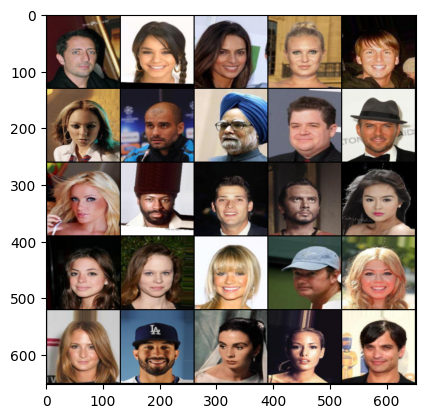

In [14]:
# Dataset, DataLoader, declare gen/crit, test dataset

class Dataset(Dataset):
    def __init__(self, path, size=128, lim=10000): # limit for demonstration
        self.sizes=[size,size] # image width and height
        items, labels = [], [] # path to the images, labels(not a supervised model, so not exact label but just filename)
        
        for data in os.listdir(path)[:lim]:
            # path : './data/celeba/img_align_celeba'
            # data : '114568.jpg'
            item = os.path.join(path,data)
            items.append(item)
            labels.append(data)
        
        self.items = items
        self.labels = labels
        
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        data = PIL.Image.open(self.items[idx]).convert('RGB') # return ex. (178x218) image
        # resize, rearrange
        data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3 numpy array
        data = np.transpose(data, (2,0,1)).astype(np.float32, copy=False) # 3 x 128 x 128 numpy array (values : 0~255 typical PIL image)
        data = torch.from_numpy(data).div(255) # tensor (values : 0~1)
        return data, self.labels[idx]
        
# Dataset
data_path = './data/celeba/img_align_celeba'
ds = Dataset(data_path, size=128, lim=10000)

# DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

# Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))

# Initializations (optional)
# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

# wandb optional
if (wandbact==1):
    wandb.watch(gen, log_freq=100)
    wandb.watch(crit, log_freq=100)

x, y = next(iter(dataloader))
show(x)